In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.spatial import distance
from IPython.display import display

OG_DATA_PATH = './MatData/'
PLOTS_PATH = './Sabine_poster/map/'
DATA_PATH = './AllData/'
os.makedirs(os.path.dirname(PLOTS_PATH), exist_ok=True)
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
sns.set(context = "poster", style="white", palette="dark", font_scale=2, rc={'figure.figsize':(12,9)})

In [2]:
# Check valid subjects
subdf = pd.read_csv('./Seahaven_alignment_project_24092019.csv', sep=';')

In [3]:
subdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 17 columns):
Unnamed: 0          527 non-null object
Experimenter        527 non-null object
Subject             527 non-null object
Measurement         527 non-null int64
Training            527 non-null object
Repeated            337 non-null object
Discarded           85 non-null object
Folder Name/link    523 non-null object
Testvers            496 non-null object
Comments            284 non-null object
Unnamed: 10         55 non-null object
Unnamed: 11         26 non-null object
Unnamed: 12         15 non-null object
Unnamed: 13         3 non-null object
Unnamed: 14         2 non-null object
Unnamed: 15         1 non-null float64
Unnamed: 16         1 non-null object
dtypes: float64(1), int64(1), object(15)
memory usage: 70.1+ KB


In [4]:
tmpdf = (
    subdf
    .query('Discarded != "yes"')
    .query('Measurement == 3')
    .query('Training == "map"')
    [['Subject']] 
)
val_subs = tmpdf.Subject.unique()  
display(val_subs)

array(['1719', '2096', '2294', '2299', '2557', '3426', '4199', '4749',
       '5048', '5162', '5904', '6449', '7085', '7396', '7844', '8021',
       '8078', '8124', '8479', '8802', '9369', '9864'], dtype=object)

In [5]:
def mat_to_df(subNr,taskType):
    '''
    converts mat struct with task results into pandas df
    also adds extra column with information whether trial was correct or wrong    
    '''
    columns = {'Absolute': ['HouseNr', 'Correct_Angle', 'Wrong_Angle', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Relative': ['PrimeNr', 'TargetNr_correct', 'TargetNr_wrong', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Pointing': ['PrimeNr', 'TargetNr', 'Angle_correct', 'Angle_wrong','Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject']
              }
    matpath = OG_DATA_PATH+"/AlignmentVR_SubjNo_"+ str(subNr) +".mat"
    if os.path.exists(matpath):
        mat_contents = spio.loadmat(matpath)
        type_array = []
        for j,cond_2 in enumerate(["Trial_3s", "Trial_Inf"]):
            trials_array = []
            for line in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0])):
                value_array = []
                for column in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0])):
                    value = mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0][column][0][0]
                    value_array.append(value)
                # check if trial is correct(true or false
                value_array.append(value_array[-1] == value_array[-3])
                value_array.extend([cond_2.split('_')[1],taskType, subNr]) 
    #                 print(value_array)
                trials_array.append(value_array)
    #             print(len(value_array))
            type_array.extend(trials_array)
    #     print(type_array)
        return pd.DataFrame.from_records(type_array, columns=columns[taskType])
    else:
        print(matpath+' NOT FOUND!')
        return pd.DataFrame()

In [6]:
abs_df = pd.concat([mat_to_df(sub, 'Absolute') for idx, sub in enumerate(val_subs)],
            ignore_index=True) 
abs_df['AngularDiff'] = abs(abs_df.Correct_Angle - abs_df.Wrong_Angle)
abs_df.loc[abs_df['AngularDiff']>180, 'AngularDiff' ] = 360 - abs_df['AngularDiff']

In [7]:
abs_df['Correct_Angle_180'] = abs_df.Correct_Angle
abs_df.loc[abs_df['Correct_Angle_180']>180, 'Correct_Angle_180' ] = 360 - abs_df['Correct_Angle_180']
display(abs_df.Correct_Angle_180.value_counts(bins=7))
bins = pd.IntervalIndex.from_tuples([(0, 10), (15, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
abs_df['AngleToNorth'], bins = pd.cut(abs_df.Correct_Angle_180, bins=7,labels=[0,30,60,90,120,150,180], retbins=True)


(128.571, 154.286]    286
(77.143, 102.857]     264
(51.429, 77.143]      264
(102.857, 128.571]    242
(25.714, 51.429]      242
(154.286, 180.0]      154
(-0.181, 25.714]      132
Name: Correct_Angle_180, dtype: int64

In [8]:
display(abs_df.AngularDiff.value_counts())

180    264
150    264
120    264
90     264
60     264
30     264
Name: AngularDiff, dtype: int64

In [9]:
rel_df = pd.concat([mat_to_df(sub, 'Relative') for idx, sub in enumerate(val_subs)],
            ignore_index=True) 
# display(rel_df)

In [10]:
point_df = pd.concat([mat_to_df(sub, 'Pointing') for idx, sub in enumerate(val_subs)],
            ignore_index=True) 
point_df['AngularDiff'] = abs(point_df.Angle_correct - point_df.Angle_wrong)
point_df.loc[point_df['AngularDiff']>180, 'AngularDiff' ] = 360 - point_df['AngularDiff']


In [21]:
display(abs_df.head())
display(rel_df.head())
display(point_df.head())

,HouseNr,Correct_Angle,Wrong_Angle,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,AngularDiff,Correct_Angle_180,AngleToNorth
0,170,243,93,U,1.911848,D,False,3s,Absolute,1719,150,117,120
1,140,303,243,U,1.730624,U,True,3s,Absolute,1719,60,57,60
2,177,155,305,D,1.968733,D,True,3s,Absolute,1719,150,155,180
3,132,120,330,U,2.527483,D,False,3s,Absolute,1719,150,120,120
4,122,30,60,D,2.286321,D,True,3s,Absolute,1719,30,30,30


,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,x_p,House,y_p,x_t,House_,y_t,Distance
0,171,147,88,D,2.398472,D,True,3s,Relative,1719,316.8,171.0,824.3,426.5,147.0,754.8,129.862774
1,189,190,19,U,2.487582,U,True,3s,Relative,1719,213.6,189.0,866.2,230.3,190.0,834.0,36.272993
2,117,110,53,U,2.156479,D,False,3s,Relative,1719,394.9,117.0,790.9,480.1,110.0,813.0,88.019600
3,180,169,125,D,1.408578,D,True,3s,Relative,1719,522.0,180.0,830.2,349.0,169.0,813.9,173.766193
4,55,50,85,D,1.669780,U,False,3s,Relative,1719,437.6,55.0,803.8,431.4,50.0,740.6,63.503386


,PrimeNr,TargetNr,Angle_correct,Angle_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,AngularDiff,x_p,House,y_p,x_t,House_,y_t,Distance
0,33,9,243,213,D,2.061093,D,True,3s,Pointing,1719,30,495.2,33.0,885.6,541.8,9.0,795.2,101.704081
1,119,146,132,72,U,NaN,N,False,3s,Pointing,1719,60,412.0,119.0,779.9,382.4,146.0,891.4,115.362082
2,156,67,306,126,D,1.653943,D,True,3s,Pointing,1719,180,462.5,156.0,656.6,290.0,67.0,783.1,213.912365
3,81,37,88,208,U,1.437038,D,False,3s,Pointing,1719,120,439.8,81.0,950.2,442.3,37.0,889.0,61.251041
4,133,65,226,16,U,1.886768,D,False,3s,Pointing,1719,150,597.1,133.0,827.9,437.4,65.0,671.2,223.738642


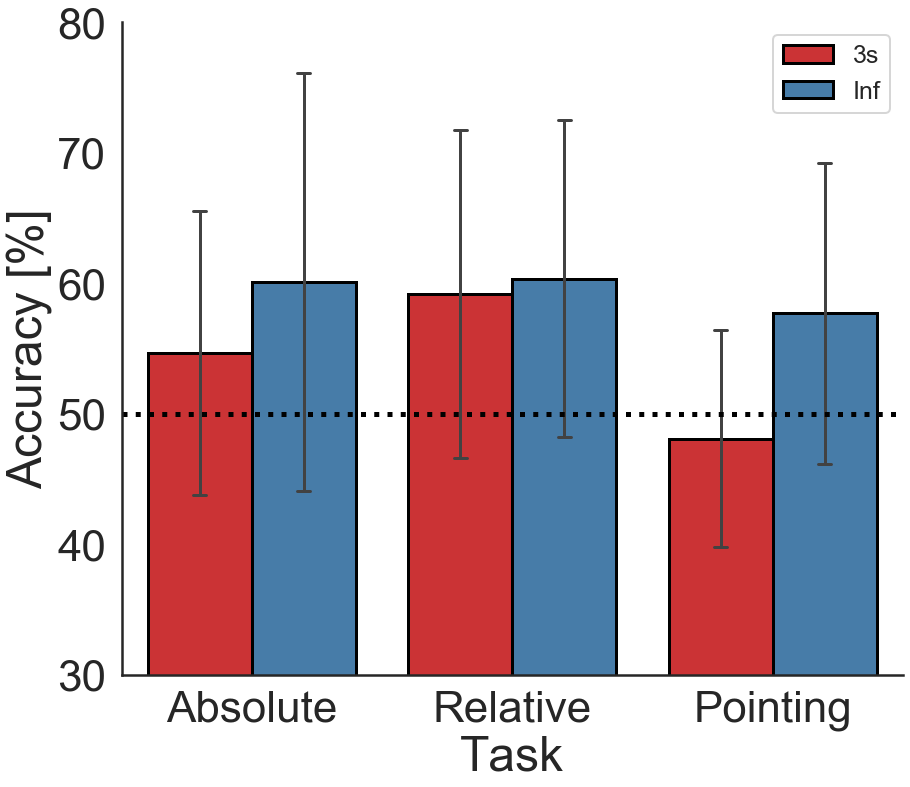

In [11]:
perf_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
# display(perf_df)
perf_df.Accuracy = perf_df.Accuracy*100
_, ax = plt.subplots(figsize=(14,12))
# palette = {'light','dark'}
sns.barplot(data=perf_df, x='Task', y='Accuracy', hue='Time',
            ci='sd',capsize=0.05, ax=ax, 
            edgecolor=(0,0,0),errwidth=3,linewidth=3,
            palette='Set1'
#             palette = ['lightskye','steeleblue','lightcoral','red','lightgreen','green']
           )
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax.axhline(50, ls=':', color='black', lw=5)
# ax.set_xlabel('Task')
ax.set(ylim=(30,80), yticks=[30,40,50,60,70, 80], ylabel='Accuracy [%]')
ax.legend(title='', loc='upper right', fontsize=25)
plt.savefig(PLOTS_PATH+'/task_accuracy.png', quality=90)

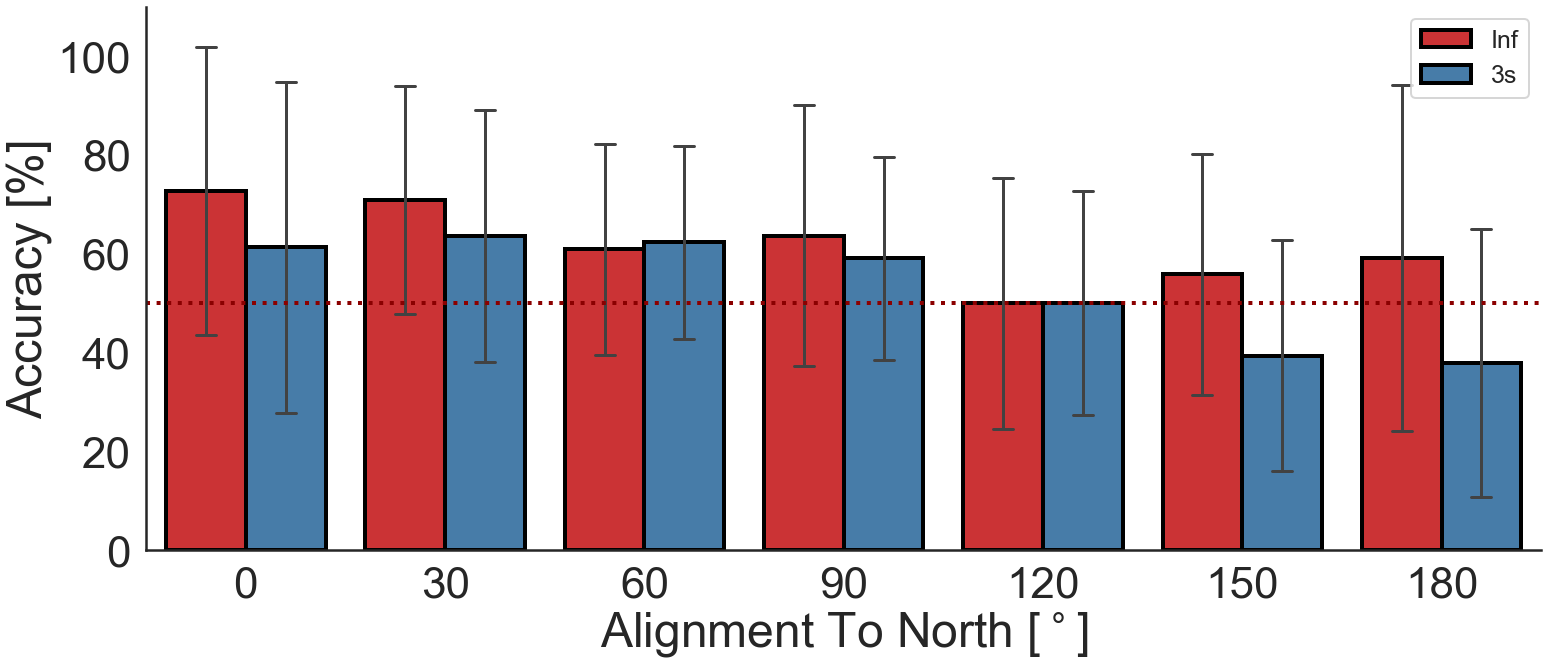

In [12]:
perf_df = (
    abs_df
    .groupby(['Subject','Task','Time','AngleToNorth'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
#     .query('Time == "3s"')
)

# display(perf_df)
perf_df.Accuracy = perf_df.Accuracy*100
_, ax = plt.subplots(figsize=(25,10))
sns.barplot(data=perf_df, x='AngleToNorth', y='Accuracy', hue='Time', hue_order=['Inf','3s'], ci='sd',capsize=0.1, ax=ax, palette='Set1',
           edgecolor=(0,0,0),errwidth=3,linewidth=4)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax.axhline(50, ls=':', color='darkred', lw=4)
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('Alignment To North [$^\circ$]')
ax.set(ylim=(0,110), yticks=[0,20,40,60,80,100])
ax.legend(title='', loc='upper right', fontsize=25)
plt.savefig(PLOTS_PATH+'/angleToNorth_accuracy_alltime.png', quality=90)

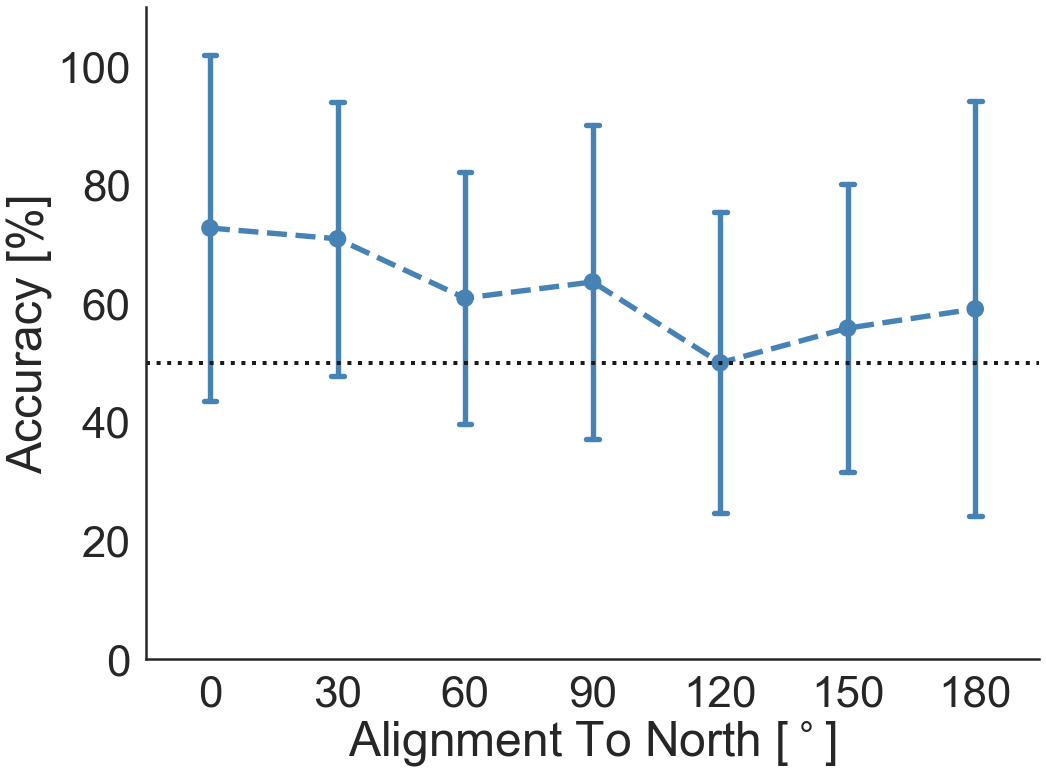

In [13]:
perf_df = (
    abs_df
    .groupby(['Subject','Task','Time','AngleToNorth'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    .query('Time == "Inf"')
)

# display(perf_df)
sns.set(context = "poster", style="white", palette="dark", font_scale=2, rc={'figure.figsize':(12,9)})
perf_df.Accuracy = perf_df.Accuracy*100
_, ax = plt.subplots(figsize=(16,12))
sns.pointplot(data=perf_df, x='AngleToNorth', y='Accuracy', ci='sd',capsize=0.1, ax=ax, color='steelblue',
              linestyles='--'
#            edgecolor=(0,0,0),errwidth=3,linewidth=4
           )
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax.axhline(50, ls=':', color='k', lw=4)
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('Alignment To North [$^\circ$]')
ax.set(ylim=(0,110), yticks=[0,20,40,60,80,100])
# ax.legend(title='', loc='upper right', fontsize=25)
plt.savefig(PLOTS_PATH+'/angleToNorth_accuracy_Inf.png', quality=90)

In [14]:
coordinates = open("./AllData/HouseList.txt","r")
coords = pd.DataFrame(columns={'House','x','y'})
for co in coordinates:
    x = float(co.split(':',1)[1].split(';',1)[0])
    y = float(co.split(';',1)[1])
    house = str(int(co.split(':',1)[0]))
    coords = coords.append({'House':int(house),'x':x,'y':y},ignore_index=True)
# coords = coords.set_index('House').sort_index()
# display(coords)


In [15]:
point_df = point_df.merge(coords, left_on='PrimeNr', right_on='House', how='left', suffixes=('',''))
point_df.rename(columns={'x':'x_p', 'y':'y_p'}, inplace=True)  

point_df = point_df.merge(coords, left_on='TargetNr', right_on='House', how='left', suffixes=('','_'))
point_df.rename(columns={'x':'x_t', 'y':'y_t'}, inplace=True)  

point_df['Distance'] = np.sqrt((point_df.x_p - point_df.x_t)**2 + (point_df.y_p - point_df.y_t)**2)

In [16]:
point_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584 entries, 0 to 1583
Data columns (total 19 columns):
PrimeNr           1584 non-null int64
TargetNr          1584 non-null int64
Angle_correct     1584 non-null int64
Angle_wrong       1584 non-null int64
Correct_Answer    1584 non-null object
RT                1553 non-null float64
Sub_Answer        1584 non-null object
Accurate          1584 non-null bool
Time              1584 non-null object
Task              1584 non-null object
Subject           1584 non-null object
AngularDiff       1584 non-null int64
x_p               1584 non-null float64
House             1584 non-null float64
y_p               1584 non-null float64
x_t               1584 non-null float64
House_            1584 non-null float64
y_t               1584 non-null float64
Distance          1584 non-null float64
dtypes: bool(1), float64(8), int64(5), object(5)
memory usage: 236.7+ KB


In [17]:
rel_df = rel_df.merge(coords, left_on='PrimeNr', right_on='House', how='left', suffixes=('','_'))
rel_df.rename(columns={'x':'x_p', 'y':'y_p'}, inplace=True)  

rel_df = rel_df.merge(coords, left_on='TargetNr_correct', right_on='House', how='left', suffixes=('','_'))
rel_df.rename(columns={'x':'x_t', 'y':'y_t'}, inplace=True)  

rel_df['Distance'] = np.sqrt((rel_df.x_p - rel_df.x_t)**2 + (rel_df.y_p - rel_df.y_t)**2)

In [18]:
rel_df.head()

,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,x_p,House,y_p,x_t,House_,y_t,Distance
0,171,147,88,D,2.398472,D,True,3s,Relative,1719,316.8,171.0,824.3,426.5,147.0,754.8,129.862774
1,189,190,19,U,2.487582,U,True,3s,Relative,1719,213.6,189.0,866.2,230.3,190.0,834.0,36.272993
2,117,110,53,U,2.156479,D,False,3s,Relative,1719,394.9,117.0,790.9,480.1,110.0,813.0,88.019600
3,180,169,125,D,1.408578,D,True,3s,Relative,1719,522.0,180.0,830.2,349.0,169.0,813.9,173.766193
4,55,50,85,D,1.669780,U,False,3s,Relative,1719,437.6,55.0,803.8,431.4,50.0,740.6,63.503386


C:\Users\akeshava\.conda\envs\conda_env\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,Accuracy,Distance,PrimeNr,TargetNr,TargetNr_correct,Task,Time
0,0.681818,31.740353,15,NaN,18.0,Relative,3s
1,0.772727,158.913089,15,NaN,36.0,Relative,3s
2,0.681818,60.406705,33,NaN,38.0,Relative,3s
3,0.772727,69.766539,33,NaN,73.0,Relative,3s
4,0.681818,91.731401,39,NaN,40.0,Relative,3s
...,...,...,...,...,...,...,...
67,0.681818,80.795297,180,70.0,NaN,Pointing,Inf
68,0.500000,169.249077,189,32.0,NaN,Pointing,Inf
69,0.590909,39.635338,189,191.0,NaN,Pointing,Inf
70,0.409091,161.044621,193,11.0,NaN,Pointing,Inf


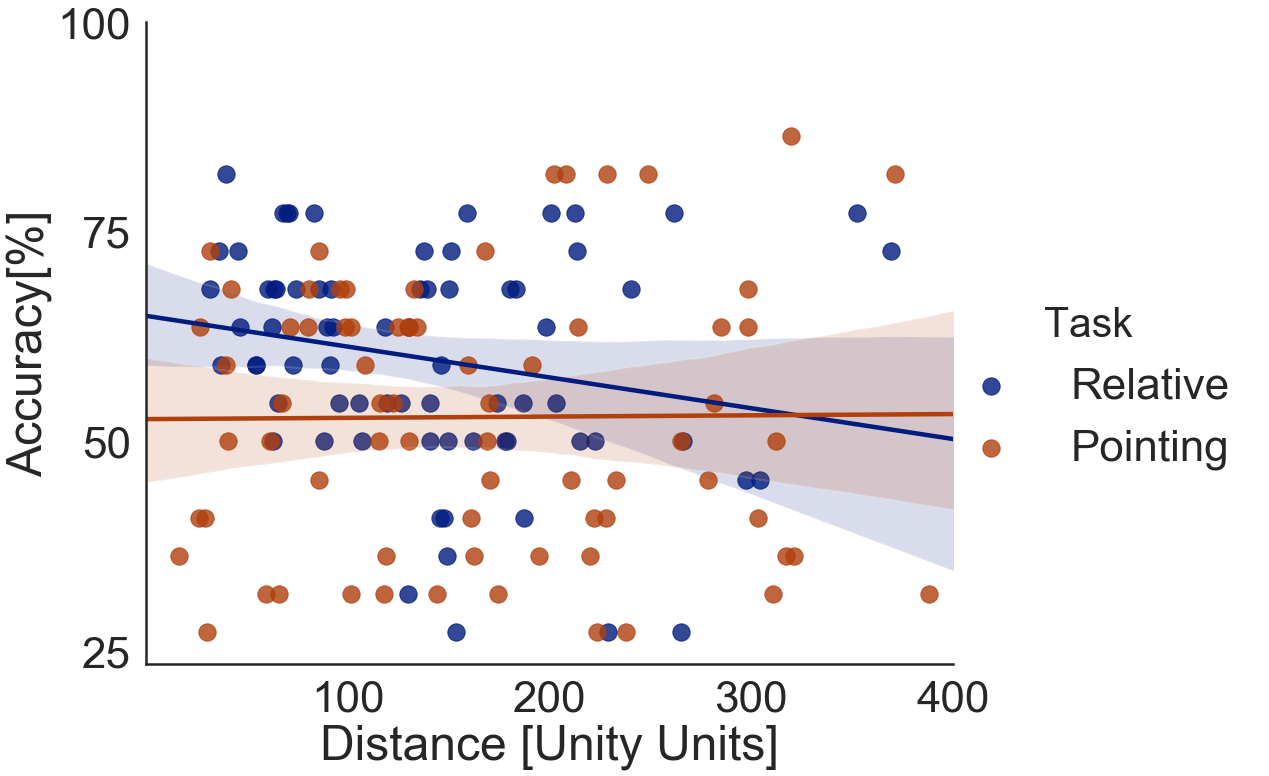

In [19]:
perf_df = pd.concat([
    (
    rel_df
    .groupby(['Task','Time','PrimeNr','TargetNr_correct', 'Distance'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Task','Time','PrimeNr','TargetNr','Distance'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
display(perf_df)
perf_df.Accuracy = perf_df.Accuracy*100
# _, ax = plt.subplots(figsize=(20,10))
sns.set(context = "poster", style="white", palette="dark", font_scale=2, rc={'figure.figsize':(11.7,8.27)})
g = sns.lmplot(data=perf_df, x='Distance', y='Accuracy',hue='Task',
               x_ci='sd', height=12, aspect=1.2, scatter_kws={"s": 300}, legend_out=True)
g = (
    g
    .set_axis_labels("Distance [Unity Units]", "Accuracy[%]")
    .set(yticks=[25,50, 75, 100])
    .set(xticks=[100,200,300,400], xlim=(0,400))
)
plt.savefig(PLOTS_PATH+'/distance_accuracy.png', quality=90)

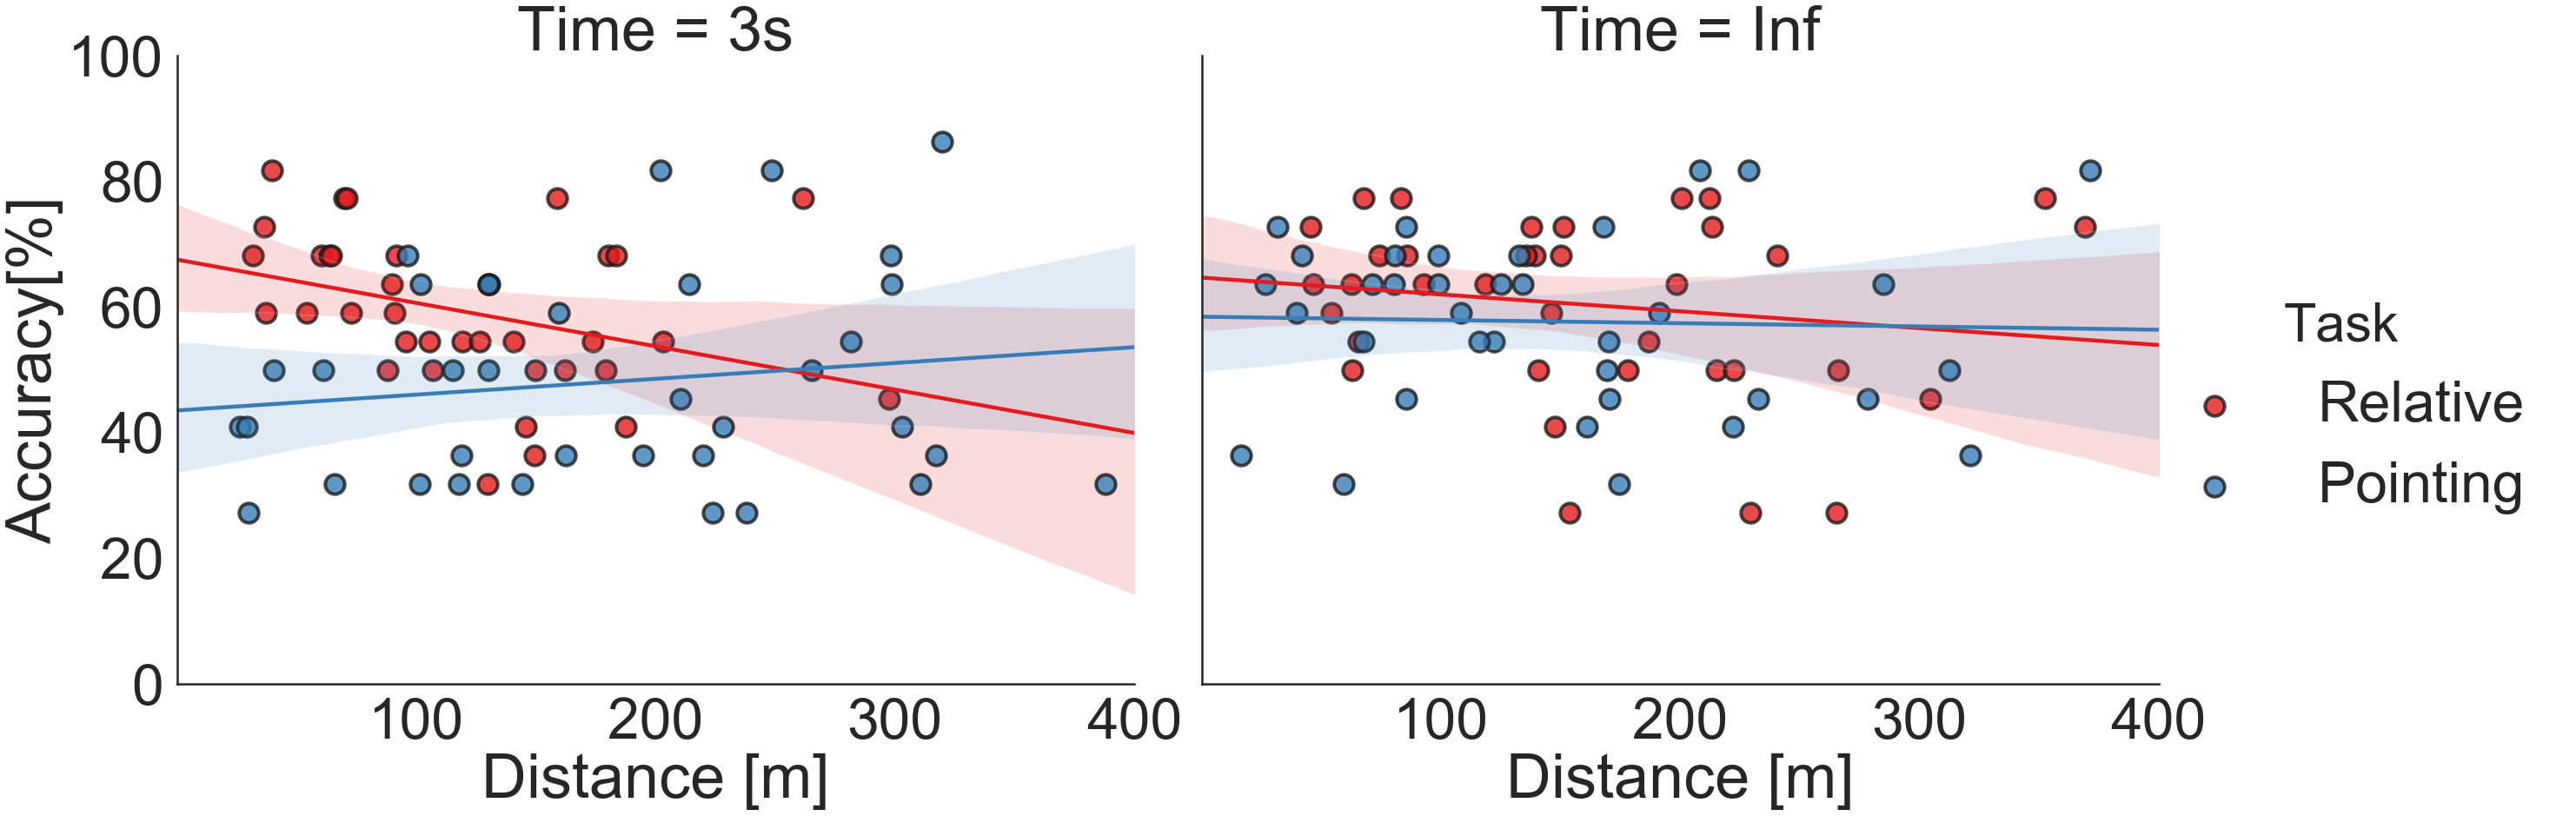

In [20]:
sns.set(context = "poster", style="white", palette="Set1", font_scale=3, rc={'figure.figsize':(12,9)})
g = sns.lmplot(data=perf_df, x='Distance', y='Accuracy',hue='Task', 
               col='Time', x_ci='sd', height=15, aspect=1.2, scatter_kws={"s": 500, 'edgecolors':'k', 'linewidths':4 })
g = (
    g
    .set_axis_labels("Distance [m]", "Accuracy[%]")
    .set(yticks=[0,20,40,60,80,100], ylim=(0,100))
    .set(xticks=[100,200,300,400], xlim=(0,400))
#     .set(ms=3)
#     .add_legend(frameon=True, framealpha=0.8, fancybox=True, shadow=False, title=None)

)

plt.savefig(PLOTS_PATH+'/distance_time_accuracy.png', quality=90)